In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from tqdm import trange
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## 1、DataCleaning

In [48]:
training_data_msa = pd.read_csv("data_msa.csv")
test_data_msa = pd.read_csv("data_msa_test.csv")
training_data_nmsa = pd.read_csv("data_nmsa.csv")
test_data_nmsa = pd.read_csv("data_nmsa_test.csv")

In [49]:
training_data_msa.head()

,source,loan_id,Year_orig,Quarter_orig,delinquent30,frst_dte,orig_rt,orig_amt,oltv,ocltv,...,seller,month,weekly_income_msa,unemployment_rate_msa,unemployment_rate,HPI_msa,HPI_state,FRM30_rate,treasury_3mon_rate,weekly_income
0,FD,F100Q1023070,2000,1,0,2000-04-01,8.500,204000,79,79,...,COUNTRYWIDE,4,691.0,5.7,6.7,118.26,169.95,8.1525,5.66,674.0
1,FD,F100Q1050054,2000,1,0,2000-03-01,8.500,173000,95,95,...,"NORWESTMORTGAGE,INC",3,691.0,6.1,7.2,118.26,169.95,8.2400,5.69,674.0
2,FD,F100Q1005553,2000,1,0,2000-03-01,8.250,92000,95,95,...,Other sellers,3,633.0,3.8,4.5,122.36,209.11,8.2400,5.69,555.0
3,FD,F100Q1009498,2000,1,1,2000-03-01,8.125,112000,80,80,...,Other sellers,3,633.0,3.8,4.5,122.36,209.11,8.2400,5.69,555.0
4,FD,F100Q1009604,2000,1,1,2000-04-01,9.500,84000,95,95,...,Other sellers,4,486.0,4.0,3.8,128.05,209.11,8.1525,5.66,555.0


In [50]:
training_data_msa.columns

Index(['source', 'loan_id', 'Year_orig', 'Quarter_orig', 'delinquent30',
       'frst_dte', 'orig_rt', 'orig_amt', 'oltv', 'ocltv', 'dti', 'cscore_b',
       'mi_pct', 'fthb_flg', 'num_bo', 'num_unit', 'state', 'cd_msa',
       'delinquent60', 'delinquent90', 'foreclosure', 'prepaid_cnt', 'seller',
       'month', 'weekly_income_msa', 'unemployment_rate_msa',
       'unemployment_rate', 'HPI_msa', 'HPI_state', 'FRM30_rate',
       'treasury_3mon_rate', 'weekly_income'],
      dtype='object')

In [51]:
training_data_nmsa.head()

,source,loan_id,Year_orig,Quarter_orig,delinquent30,frst_dte,orig_rt,orig_amt,oltv,ocltv,...,delinquent90,foreclosure,prepaid_cnt,seller,month,unemployment_rate,HPI_state,FRM30_rate,treasury_3mon_rate,weekly_income
0,FD,F100Q1039162,2000,1,0,2000-05-01,8.375,100000,34,34,...,0,0,1,"NORWESTMORTGAGE,INC",5,6.4,169.95,8.5150,5.79,674.0
1,FD,F100Q1002153,2000,1,0,2000-03-01,8.125,137000,80,80,...,0,0,1,"NORWESTMORTGAGE,INC",3,4.5,209.11,8.2400,5.69,555.0
2,FD,F100Q1010264,2000,1,0,2000-04-01,8.750,100000,97,97,...,0,0,1,Other sellers,4,3.8,209.11,8.1525,5.66,555.0
3,FD,F100Q1013230,2000,1,0,2000-03-01,7.625,174000,87,87,...,0,0,0,"NORWESTMORTGAGE,INC",3,4.5,209.11,8.2400,5.69,555.0
4,FD,F100Q1022057,2000,1,0,2000-03-01,8.000,100000,64,64,...,0,0,1,COUNTRYWIDE,3,4.5,209.11,8.2400,5.69,555.0


In [52]:
selected_columns_nmsa = ['source','Quarter_orig','orig_rt' ,'orig_amt',  'oltv' , 'ocltv' , 'dti' , 'cscore_b' , 'mi_pct'  , 'num_bo' ,\
          'num_unit' ,'fthb_flg', 'FRM30_rate','treasury_3mon_rate','weekly_income','foreclosure', 'prepaid_cnt', 'unemployment_rate','delinquent30'] 

In [53]:
selected_columns_msa = selected_columns_nmsa + ["weekly_income_msa", "HPI_msa", "unemployment_rate_msa"]

In [54]:
training_data_msa = training_data_msa.reindex(columns=selected_columns_msa)
test_data_msa = test_data_msa.reindex(columns=selected_columns_msa)
training_data_nmsa = training_data_nmsa.reindex(columns=selected_columns_nmsa)
test_data_nmsa = test_data_nmsa.reindex(columns=selected_columns_nmsa)

In [55]:
training_data_msa = training_data_msa.fillna(method='ffill')
test_data_msa = test_data_msa.fillna(method='ffill')
training_data_nmsa = training_data_nmsa.fillna(method='ffill')
test_data_nmsa = test_data_nmsa.fillna(method='ffill')
sum(training_data_msa.isnull().any()), sum(test_data_msa.isnull().any()),sum(training_data_nmsa.isnull().any()), sum(test_data_nmsa.isnull().any())

(0, 0, 0, 0)

In [56]:
training_data_msa = pd.get_dummies(training_data_msa)
test_data_msa = pd.get_dummies(test_data_msa)
training_data_nmsa = pd.get_dummies(training_data_nmsa)
test_data_nmsa = pd.get_dummies(test_data_nmsa)

training_data_msa = pd.DataFrame(training_data_msa, dtype=np.float32)
test_data_msa = pd.DataFrame(test_data_msa, dtype=np.float32)
training_data_nmsa = pd.DataFrame(training_data_nmsa, dtype=np.float32)
test_data_nmsa = pd.DataFrame(test_data_nmsa, dtype=np.float32)

## 2、Utils

In [57]:
features_msa = list(training_data_msa.columns)
features_msa.remove("delinquent30")
features_nmsa = list(training_data_nmsa.columns)
features_nmsa.remove("delinquent30")
label = "delinquent30"

In [58]:
X_train_msa = training_data_msa[features_msa].values
y_train_msa = training_data_msa[label].values
X_test_msa = test_data_msa[features_msa].values
y_test_msa = test_data_msa[label].values

X_train_nmsa = training_data_msa[features_nmsa].values
y_train_nmsa = training_data_msa[label].values
X_test_nmsa = test_data_nmsa[features_nmsa].values
y_test_nmsa = test_data_nmsa[label].values

In [59]:
print(X_train_msa.shape, y_train_msa.shape, X_test_msa.shape, y_test_msa.shape)
print(X_train_nmsa.shape, y_train_nmsa.shape, X_test_nmsa.shape, y_test_nmsa.shape)

(247274, 22) (247274,) (38597, 22) (38597,)
(247274, 19) (247274,) (6915, 19) (6915,)


In [60]:
sc=StandardScaler()
X_train_msa_sc = sc.fit_transform(X_train_msa)
X_test_msa_sc = sc.transform(X_test_msa)
X_train_nmsa_sc = sc.fit_transform(X_train_nmsa)
X_test_nmsa_sc = sc.transform(X_test_nmsa)

In [85]:
selector = SelectKBest(chi2, k=13)
selector.fit(X_train_msa, y_train_msa)
X_train_msa_select = selector.transform(X_train_msa)
X_test_msa_select = selector.transform(X_test_msa)

X_train_msa_sc_select = sc.fit_transform(X_train_msa_select)
X_test_msa_sc_select = sc.transform(X_test_msa_select)

selector = SelectKBest(chi2, k=13)
selector.fit(X_train_nmsa, y_train_nmsa)
X_train_nmsa_select = selector.transform(X_train_nmsa)
X_test_nmsa_select = selector.transform(X_test_nmsa)

X_train_nmsa_sc_select = sc.fit_transform(X_train_nmsa_select)
X_test_nmsa_sc_select = sc.transform(X_test_nmsa_select)

In [86]:
def compare(y_pred,y):
    """
    calculate the number of tp, fp, fn, tn of prediction
    """
    tp = np.sum((y_pred==True)&(y==1))
    fp = np.sum((y_pred==True)&(y==0))
    fn = np.sum((y_pred==False)&(y==1))
    tn = np.sum((y_pred==False)&(y==0))
    return tp,fp,fn,tn

In [87]:
def cal_net_profit(y_pred, y, test_data):
    """
    calculate the net profit under the prediction of y_pred
    """
    orig_amt = test_data['orig_amt'].values
    true_index = np.where(((y==0) & (y_pred==0)) == True)[0]
    false_index = np.where(((y==1) & (y_pred==0)) == True)[0]
    #print(len(true_index), len(false_index))
    #print(true_index, false_index)
    profit = np.sum(orig_amt[true_index] * 0.005)
    loss = np.sum(orig_amt[false_index] * 0.2)
    return profit - loss

In [88]:
ori_net_profit = cal_net_profit(np.array([0]*len(y_test_msa)), y_test_msa, test_data_msa) +\
                cal_net_profit(np.array([0]*len(y_test_nmsa)), y_test_nmsa, test_data_nmsa)

# 3、Logistic Regression

In [89]:
lr_clf_msa = LogisticRegression(max_iter=200)
lr_clf_nmsa = LogisticRegression(max_iter=200)

In [90]:
#未标准化
lr_clf_msa.fit(X_train_msa, y_train_msa)
result_msa = lr_clf_msa.predict(X_test_msa)
lr_clf_nmsa.fit(X_train_nmsa, y_train_nmsa)
result_nmsa = lr_clf_nmsa.predict(X_test_nmsa)
print(classification_report(y_test_msa,result_msa))
print(classification_report(y_test_nmsa,result_nmsa))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     36301
         1.0       0.00      0.00      0.00      2296

    accuracy                           0.94     38597
   macro avg       0.47      0.50      0.48     38597
weighted avg       0.88      0.94      0.91     38597

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      6501
         1.0       0.00      0.00      0.00       414

    accuracy                           0.94      6915
   macro avg       0.47      0.50      0.48      6915
weighted avg       0.88      0.94      0.91      6915



In [91]:
ps = [i/100 for i in range(100)]
errors = [] 
T1s = []
T2s = []
net_profits = []
for i in trange(len(ps)):
    p = ps[i]
    y_pred_msa = np.where(lr_clf_msa.predict_proba(X_test_msa)[:,1] > p, 1, 0)
    y_pred_nmsa = np.where(lr_clf_nmsa.predict_proba(X_test_nmsa)[:,1] > p, 1, 0)
    tp_msa,fp_msa,fn_msa,tn_msa = compare(y_pred_msa, y_test_msa)
    tp_nmsa,fp_nmsa,fn_nmsa,tn_nmsa = compare(y_pred_nmsa, y_test_nmsa) 
    net_profit = cal_net_profit(y_pred_msa, y_test_msa, test_data_msa) + cal_net_profit(y_pred_nmsa, y_test_nmsa, test_data_nmsa)
    tp = tp_msa + tp_nmsa
    fp = fp_msa + fp_nmsa
    fn = fn_msa + fn_nmsa
    tn = tn_msa + tn_nmsa
    error = (fn+fp) / (tp+fp+fn+tn)
    T1e = fp/(tn+fp)
    T2e = fn/(fn+tp)
    errors.append(error)
    T1s.append(T1e)
    T2s.append(T2e)
    net_profits.append(net_profit-ori_net_profit)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 89.89it/s]


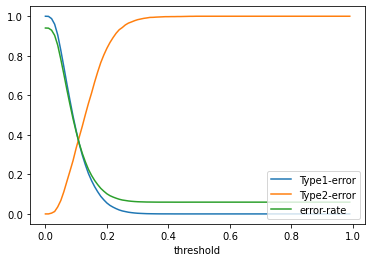

In [92]:
plt.plot(ps,T1s,label='Type1-error')
plt.plot(ps,T2s,label='Type2-error')
plt.plot(ps,errors,label='error-rate')
plt.xlabel("threshold")
plt.legend(loc="lower right")

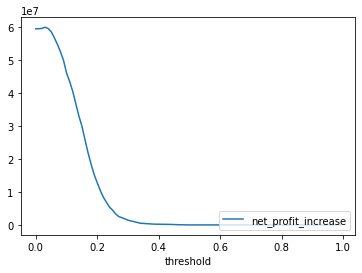

In [93]:
plt.plot(ps,net_profits, label='net_profit_increase')
plt.xlabel("threshold")
plt.legend(loc="lower right")

In [94]:
ps[np.argmax(net_profits)],net_profits[3]

(0.03, 60046064.0)

In [95]:
#标准化
lr_clf_msa.fit(X_train_msa_sc, y_train_msa)
result_msa = lr_clf_msa.predict(X_test_msa_sc)
lr_clf_nmsa.fit(X_train_nmsa_sc, y_train_nmsa)
result_nmsa = lr_clf_nmsa.predict(X_test_nmsa_sc)
print(classification_report(y_test_msa,result_msa))
print(classification_report(y_test_nmsa,result_nmsa))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     36301
         1.0       1.00      0.05      0.09      2296

    accuracy                           0.94     38597
   macro avg       0.97      0.52      0.53     38597
weighted avg       0.95      0.94      0.92     38597

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      6501
         1.0       1.00      0.08      0.15       414

    accuracy                           0.95      6915
   macro avg       0.97      0.54      0.56      6915
weighted avg       0.95      0.95      0.92      6915



In [96]:
ps = [i/100 for i in range(100)]
errors = [] 
T1s = []
T2s = []
net_profits = []
for i in trange(len(ps)):
    p = ps[i]
    y_pred_msa = np.where(lr_clf_msa.predict_proba(X_test_msa_sc)[:,1] > p, 1, 0)
    y_pred_nmsa = np.where(lr_clf_nmsa.predict_proba(X_test_nmsa_sc)[:,1] > p, 1, 0)
    tp_msa,fp_msa,fn_msa,tn_msa = compare(y_pred_msa, y_test_msa)
    tp_nmsa,fp_nmsa,fn_nmsa,tn_nmsa = compare(y_pred_nmsa, y_test_nmsa) 
    net_profit = cal_net_profit(y_pred_msa, y_test_msa, test_data_msa) + cal_net_profit(y_pred_nmsa, y_test_nmsa, test_data_nmsa)
    tp = tp_msa + tp_nmsa
    fp = fp_msa + fp_nmsa
    fn = fn_msa + fn_nmsa
    tn = tn_msa + tn_nmsa
    error = (fn+fp) / (tp+fp+fn+tn)
    T1e = fp/(tn+fp)
    T2e = fn/(fn+tp)
    errors.append(error)
    T1s.append(T1e)
    T2s.append(T2e)
    net_profits.append(net_profit-ori_net_profit)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 88.57it/s]


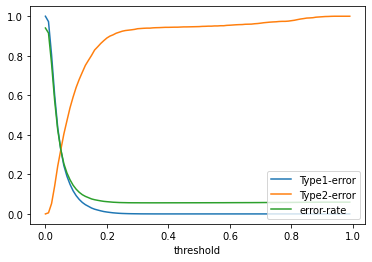

In [97]:
plt.plot(ps,T1s,label='Type1-error')
plt.plot(ps,T2s,label='Type2-error')
plt.plot(ps,errors,label='error-rate')
plt.xlabel("threshold")
plt.legend(loc="lower right")

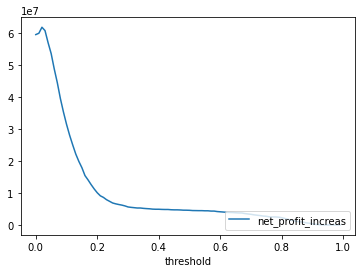

In [98]:
plt.plot(ps,net_profits,label='net_profit_increas')
plt.xlabel("threshold")
plt.legend(loc="lower right")

In [99]:
ps[np.argmax(net_profits)],net_profits[2]

(0.02, 61878332.0)

In [100]:
#标准化+特征选择
lr_clf_msa.fit(X_train_msa_sc_select, y_train_msa)
result_msa = lr_clf_msa.predict(X_test_msa_sc_select)
lr_clf_nmsa.fit(X_train_nmsa_sc_select, y_train_nmsa)
result_nmsa = lr_clf_nmsa.predict(X_test_nmsa_sc_select)
print(classification_report(y_test_msa,result_msa))
print(classification_report(y_test_nmsa,result_nmsa))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     36301
         1.0       1.00      0.05      0.10      2296

    accuracy                           0.94     38597
   macro avg       0.97      0.53      0.53     38597
weighted avg       0.95      0.94      0.92     38597

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      6501
         1.0       1.00      0.08      0.15       414

    accuracy                           0.95      6915
   macro avg       0.97      0.54      0.56      6915
weighted avg       0.95      0.95      0.92      6915



In [101]:
ps = [i/100 for i in range(100)]
errors = [] 
T1s = []
T2s = []
net_profits = []
for i in trange(len(ps)):
    p = ps[i]
    y_pred_msa = np.where(lr_clf_msa.predict_proba(X_test_msa_sc_select)[:,1] > p, 1, 0)
    y_pred_nmsa = np.where(lr_clf_nmsa.predict_proba(X_test_nmsa_sc_select)[:,1] > p, 1, 0)
    tp_msa,fp_msa,fn_msa,tn_msa = compare(y_pred_msa, y_test_msa)
    tp_nmsa,fp_nmsa,fn_nmsa,tn_nmsa = compare(y_pred_nmsa, y_test_nmsa) 
    net_profit = cal_net_profit(y_pred_msa, y_test_msa, test_data_msa) + cal_net_profit(y_pred_nmsa, y_test_nmsa, test_data_nmsa)
    tp = tp_msa + tp_nmsa
    fp = fp_msa + fp_nmsa
    fn = fn_msa + fn_nmsa
    tn = tn_msa + tn_nmsa
    error = (fn+fp) / (tp+fp+fn+tn)
    T1e = fp/(tn+fp)
    T2e = fn/(fn+tp)
    errors.append(error)
    T1s.append(T1e)
    T2s.append(T2e)
    net_profits.append(net_profit-ori_net_profit)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 124.09it/s]


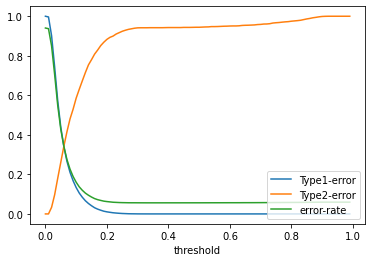

In [102]:
plt.plot(ps,T1s,label='Type1-error')
plt.plot(ps,T2s,label='Type2-error')
plt.plot(ps,errors,label='error-rate')
plt.xlabel("threshold")
plt.legend(loc="lower right")

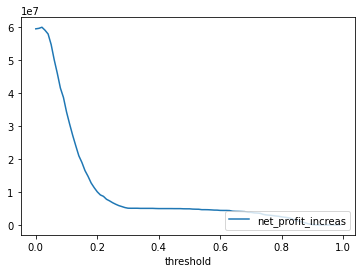

In [103]:
plt.plot(ps,net_profits,label='net_profit_increas')
plt.xlabel("threshold")
plt.legend(loc="lower right")

In [105]:
ps[np.argmax(net_profits)],net_profits[2]

(0.02, 60062680.0)

## 4、DecisionTree

In [106]:
tree_clf_msa = DecisionTreeClassifier(class_weight={0:1.0, 1:10})
tree_clf_nmsa = DecisionTreeClassifier(class_weight={0:1.0, 1:10})

tree_clf_msa.fit(X_train_msa_sc_select, y_train_msa)
result_msa = tree_clf_msa.predict(X_test_msa_sc_select)
tree_clf_nmsa.fit(X_train_nmsa_sc_select, y_train_nmsa)
result_nmsa = tree_clf_nmsa.predict(X_test_nmsa_sc_select)
print(classification_report(y_test_msa,result_msa))
print(classification_report(y_test_nmsa,result_nmsa))

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94     36301
         1.0       0.14      0.15      0.15      2296

    accuracy                           0.90     38597
   macro avg       0.54      0.55      0.55     38597
weighted avg       0.90      0.90      0.90     38597

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      6501
         1.0       0.18      0.16      0.17       414

    accuracy                           0.90      6915
   macro avg       0.56      0.56      0.56      6915
weighted avg       0.90      0.90      0.90      6915



In [107]:
weights = [i for i in range(10,200,10)]
errors = [] 
T1s = []
T2s = []
net_profits = []
for i in trange(len(weights)):
    weight = {0:1.0, 1:weights[i]}
    tree_clf_msa = DecisionTreeClassifier(class_weight=weight)
    tree_clf_nmsa = DecisionTreeClassifier(class_weight=weight)
    tree_clf_msa.fit(X_train_msa_sc_select, y_train_msa)
    y_pred_msa = tree_clf_msa.predict(X_test_msa_sc_select)
    tree_clf_nmsa.fit(X_train_nmsa_sc_select, y_train_nmsa)
    y_pred_nmsa = tree_clf_nmsa.predict(X_test_nmsa_sc_select)
    tp_msa,fp_msa,fn_msa,tn_msa = compare(y_pred_msa, y_test_msa)
    tp_nmsa,fp_nmsa,fn_nmsa,tn_nmsa = compare(y_pred_nmsa, y_test_nmsa) 
    net_profit = cal_net_profit(y_pred_msa, y_test_msa, test_data_msa) + cal_net_profit(y_pred_nmsa, y_test_nmsa, test_data_nmsa)
    tp = tp_msa + tp_nmsa
    fp = fp_msa + fp_nmsa
    fn = fn_msa + fn_nmsa
    tn = tn_msa + tn_nmsa
    error = (fn+fp) / (tp+fp+fn+tn)
    T1e = fp/(tn+fp)
    T2e = fn/(fn+tp)
    errors.append(error)
    T1s.append(T1e)
    T2s.append(T2e)
    net_profits.append(net_profit-ori_net_profit)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [02:18<00:00,  7.31s/it]


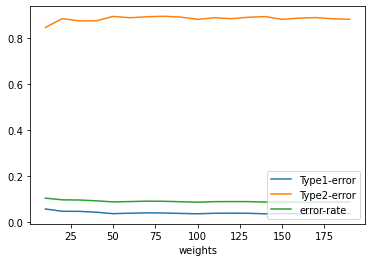

In [108]:
plt.plot(weights,T1s,label='Type1-error')
plt.plot(weights,T2s,label='Type2-error')
plt.plot(weights,errors,label='error-rate')
plt.xlabel("weights")
plt.legend(loc="lower right")

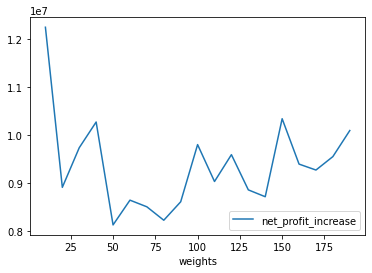

In [109]:
plt.plot(weights,net_profits,label='net_profit_increase')
plt.xlabel("weights")
plt.legend(loc="lower right")

## 5、RandomForest

In [111]:
rf_clf_msa = RandomForestClassifier()
rf_clf_nmsa = RandomForestClassifier()

rf_clf_msa.fit(X_train_msa_sc_select, y_train_msa)
result_msa = rf_clf_msa.predict(X_test_msa_sc_select)
rf_clf_nmsa.fit(X_train_nmsa_sc_select, y_train_nmsa)
result_nmsa = rf_clf_nmsa.predict(X_test_nmsa_sc_select)
print(classification_report(y_test_msa,result_msa))
print(classification_report(y_test_nmsa,result_nmsa))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     36301
         1.0       0.98      0.05      0.10      2296

    accuracy                           0.94     38597
   macro avg       0.96      0.53      0.54     38597
weighted avg       0.95      0.94      0.92     38597

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      6501
         1.0       0.97      0.09      0.16       414

    accuracy                           0.95      6915
   macro avg       0.96      0.54      0.57      6915
weighted avg       0.95      0.95      0.92      6915



In [115]:
weights = [i for i in range(10,200,10)]
errors = [] 
T1s = []
T2s = []
net_profits = []
for i in trange(len(weights)):
    weight = {0:1.0, 1:weights[i]}
    rf_clf_msa = RandomForestClassifier(class_weight=weight)
    rf_clf_nmsa = RandomForestClassifier(class_weight=weight)
    rf_clf_msa.fit(X_train_msa_sc_select, y_train_msa)
    y_pred_msa = rf_clf_msa.predict(X_test_msa_sc_select)
    rf_clf_nmsa.fit(X_train_nmsa_sc_select, y_train_nmsa)
    y_pred_nmsa = rf_clf_nmsa.predict(X_test_nmsa_sc_select)
    tp_msa,fp_msa,fn_msa,tn_msa = compare(y_pred_msa, y_test_msa)
    tp_nmsa,fp_nmsa,fn_nmsa,tn_nmsa = compare(y_pred_nmsa, y_test_nmsa) 
    net_profit = cal_net_profit(y_pred_msa, y_test_msa, test_data_msa) + cal_net_profit(y_pred_nmsa, y_test_nmsa, test_data_nmsa)
    tp = tp_msa + tp_nmsa
    fp = fp_msa + fp_nmsa
    fn = fn_msa + fn_nmsa
    tn = tn_msa + tn_nmsa
    error = (fn+fp) / (tp+fp+fn+tn)
    T1e = fp/(tn+fp)
    T2e = fn/(fn+tp)
    errors.append(error)
    T1s.append(T1e)
    T2s.append(T2e)
    net_profits.append(net_profit-ori_net_profit)

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [41:07<00:00, 129.84s/it]


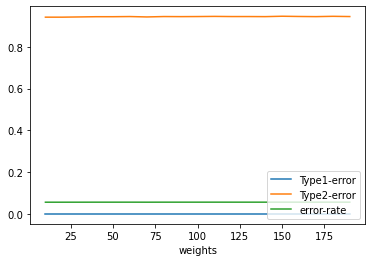

In [116]:
plt.plot(weights,T1s,label='Type1-error')
plt.plot(weights,T2s,label='Type2-error')
plt.plot(weights,errors,label='error-rate')
plt.xlabel("weights")
plt.legend(loc="lower right")

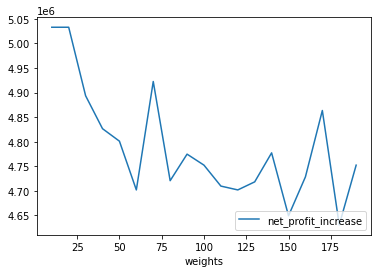

In [117]:
plt.plot(weights,net_profits,label='net_profit_increase')
plt.xlabel("weights")
plt.legend(loc="lower right")